In [1]:
import sys
import numpy as np
from scipy.spatial import ConvexHull
from scipy import sparse
import pandas as pd
from sklearn.manifold import MDS #If you want the scikit learn mds
import toolbox_2
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
R=100000
NbmaxEpi=15 #Epi states go from 0 to 15
alpha=0.227
selectedmark=1 #index of the selected mark
HiCfilename='chr1_100kb.RAWobserved'

# loading matrix
A=np.loadtxt(HiCfilename)
A=np.int_(A)
print('Input data shape : ',np.shape(A))
A=np.concatenate((A,np.transpose(np.array([A[:,1],A[:,0],A[:,2]]))), axis=0)#build array at pb resolution
A = sparse.coo_matrix( (A[:,2], (A[:,0],A[:,1])))
binned_map=toolbox_2.bin2d(A,R,R) #!become csr sparse array
LENTEST=np.shape(A)[0]
print('Input at the good resolution : ',np.shape(binned_map))

del A #keep space

Input data shape :  (2435300, 3)
Input at the good resolution :  (2493, 2493)


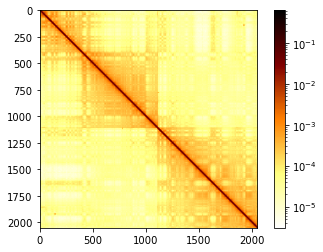

In [3]:
# filtering
filtered_map, binsaved = toolbox_2.filteramat(binned_map)
# SCN
D = toolbox_2.SCN(filtered_map)
plt.imshow(D, norm=LogNorm(), cmap='afmhot_r')
plt.colorbar()
plt.show()

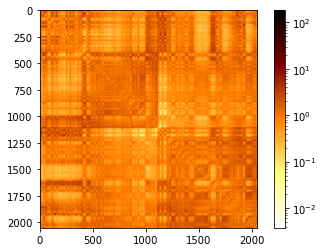

In [4]:
# Observed under expected
D = toolbox_2.observed_expected(D)
plt.imshow(D, norm=LogNorm(), cmap='afmhot_r')
plt.colorbar()
plt.show()

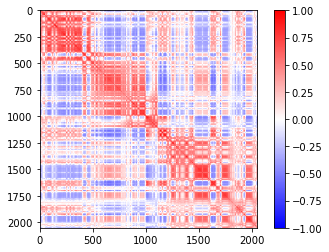

In [5]:
# pearson correlation
D = np.corrcoef(D)
plt.imshow(D, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

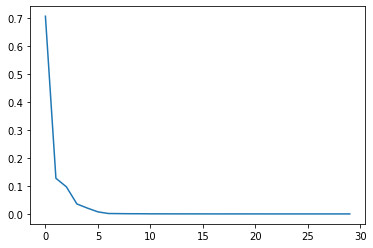

In [6]:
from sklearn import decomposition
pca30 = decomposition.PCA(n_components=30)
res30 = pca30.fit_transform(D)
plt.plot(pca30.explained_variance_ratio_)
plt.show()

In [7]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=5)
res = pca.fit_transform(D)
res_trimmed = np.delete(res, 1, 1)


In [8]:
epi = np.load('Epi1.npy')   # juz obrobione

labels = ['TssA', 'TssAFlnk', 'TxFlnk', 'Tx', 'TxWk', 'EnhG', 'Enh', 'ZNF/Rpts', 
          'Het', 'TssBiv', 'BivFlnk', 'EnhBiv', 'ReprPC', 'ReprPCWk', 'Quies']
colors = [(255,0,0), (255,69,0), (50,205,50), (0,128,0), (0,100,0), (194,225,5),
          (255,255,0), (102,205,170), (138,145,208), (205,92,92), (233,150,122),
          (189,183,107), (128,128,128), (192,192,192), (255,255,255)]

In [9]:
coverages = [0.7, 0.5, 0.1, 3.6, 11.6, 0.4, 2.8, 0.2, 2.6, 0.1, 0.1, 0.1, 1.2, 8.3, 67.8]
coverages = np.array([c/100 for c in coverages])

In [10]:
def score(data, compartments_nr, score_function):
    comps = toolbox_2.makecompartimentbyGaussianHMM(data, N=compartments_nr)[1]
    epi_heights = []
    for k in range(compartments_nr):
        epi_k = np.mean(epi[comps==k], axis=0)/coverages #vectors of normalised markers' values  
        epi_heights.append(epi_k)
    values = []
    for i in range(len(epi_heights)-1): 
        for j in range(i+1, len(epi_heights)):
            differences = abs(epi_heights[i] - epi_heights[j])
            values.append(score_function(differences))
    return sum(values)/len(values)
                

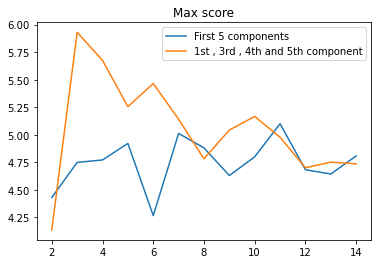

In [11]:
import matplotlib.pyplot as plt
cmp_sizes = range(2,15)
x = [i for i in cmp_sizes]
y_max = [score(res, i, max) for i in cmp_sizes]
y_trimmed_max = [score(res_trimmed, i, max) for i in cmp_sizes]
plt.plot(x,y_max,label="First 5 components")
plt.plot(x, y_trimmed_max, label="1st , 3rd , 4th and 5th component")
plt.title("Max score")
plt.legend()
plt.show()

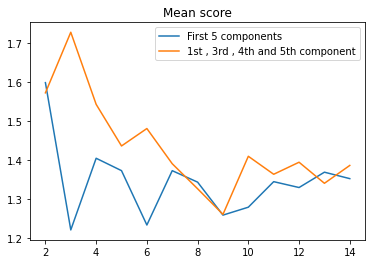

In [13]:
from  numpy import mean
x = [i for i in cmp_sizes]
y_mean = [score(res, i, mean) for i in cmp_sizes]
y_trimmed_mean = [score(res_trimmed, i, mean) for i in cmp_sizes]
plt.plot(x,y_mean,label="First 5 components")
plt.plot(x, y_trimmed_mean, label="1st , 3rd , 4th and 5th component")
plt.legend()
plt.title("Mean score")
plt.show()

In [14]:
colors = [(255,0,0), (255,69,0), (50,205,50), (0,128,0), (0,100,0), (194,225,5),
          (255,255,0), (102,205,170), (138,145,208), (205,92,92), (233,150,122),
          (189,183,107), (128,128,128), (192,192,192), (255,255,255)]
for i in range(15):
    colors[i] = (colors[i][0]/255, colors[i][1]/255, colors[i][2]/255)

def plot_epi(data):
    for c in range(2, 6):
        comps = toolbox_2.makecompartimentbyGaussianHMM(data, N=c)[1]
        rows = int(np.ceil(c/3))
        fig, axes = plt.subplots(rows, 3, figsize=(18,rows*7), sharey=True)
        axes = axes.reshape(rows,3)
        k = 0
        for i in range(rows):
            for j in range(3):
                markers = np.mean(epi[comps==k], axis=0)/coverages
                axes[i,j].bar(range(15), markers, edgecolor='k', color=colors)
                axes[i,j].colors = colors
                axes[i,j].set_xticks(range(15))
                axes[i,j].set_xticklabels(labels, rotation=60, ha='right', rotation_mode='anchor')
                axes[i,j].set_axisbelow(True)
                axes[i,j].grid(True, axis='y')
                axes[i,j].set_title('Compartment ' + str(k+1))
                k+=1
                if k==c:
                    if c%3==1:
                        fig.delaxes(axes[i,1])
                        fig.delaxes(axes[i,2])
                    elif c%3==2:
                        fig.delaxes(axes[i,2])
                    break
        plt.suptitle(str(c) + ' compartments', size=16)
        plt.show()

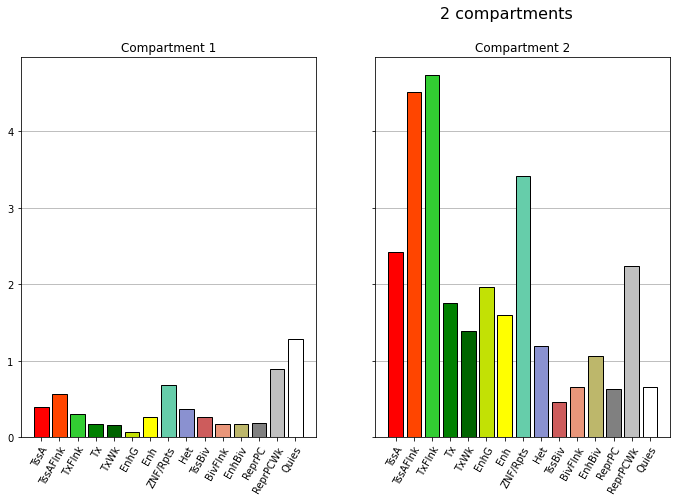

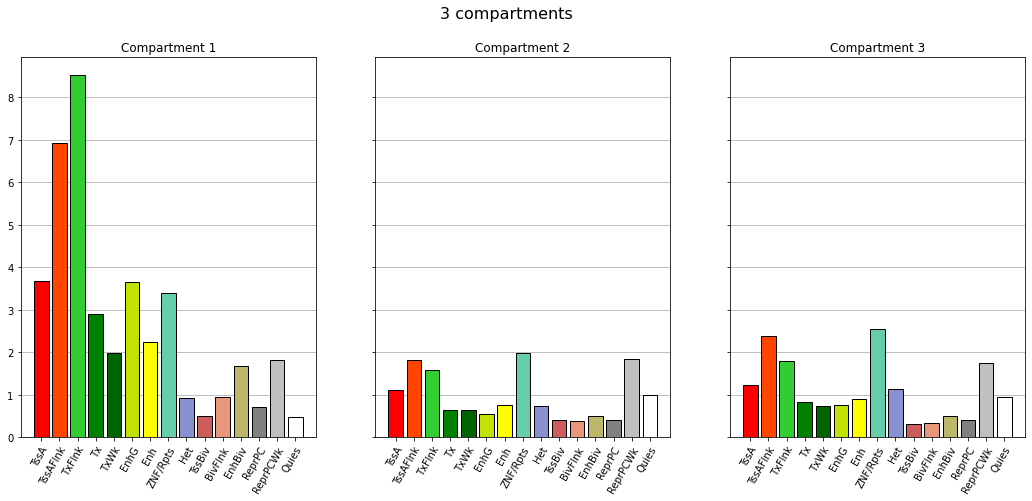

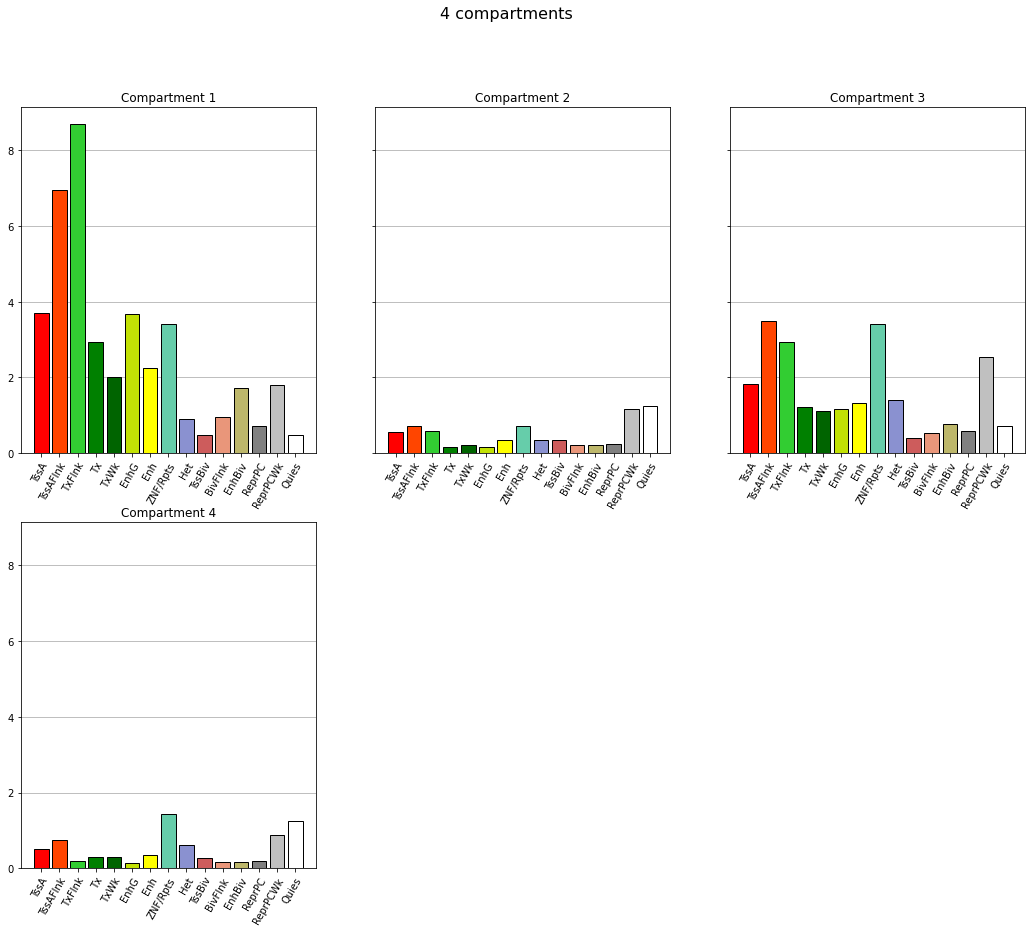

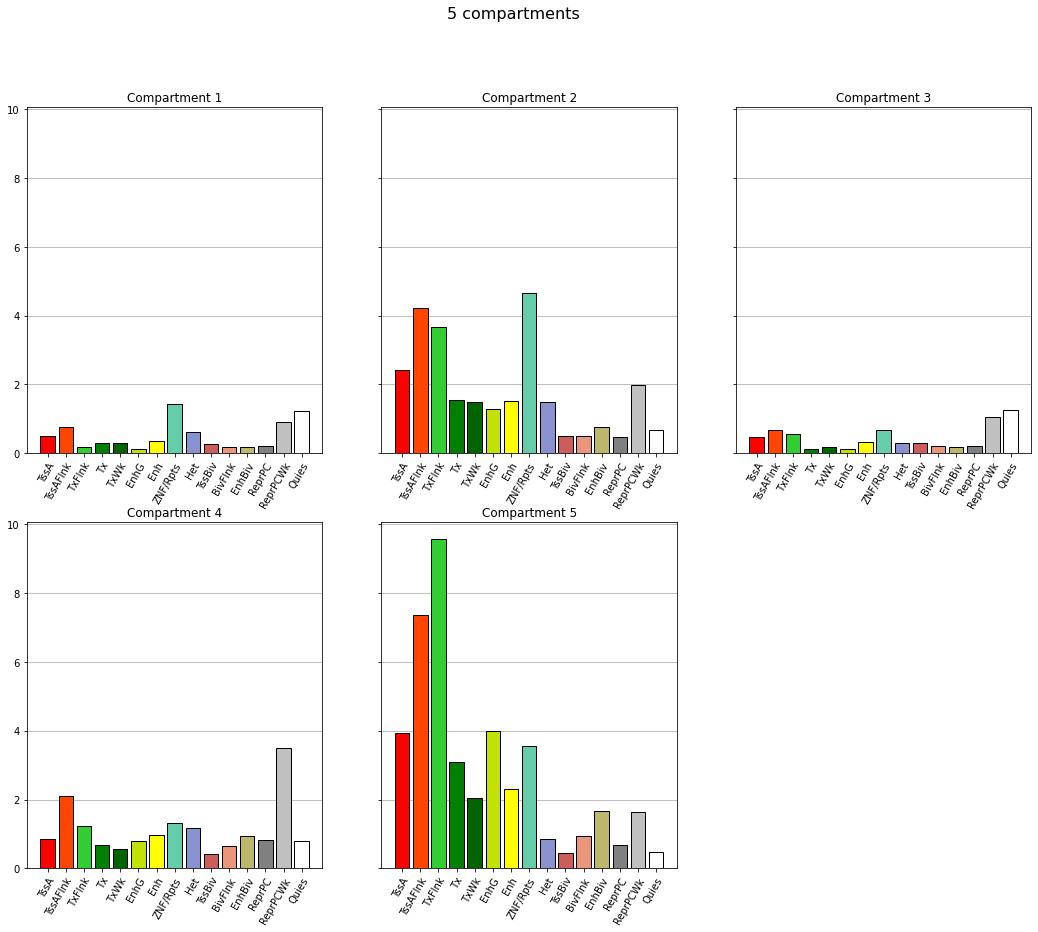

In [15]:
plot_epi(res)

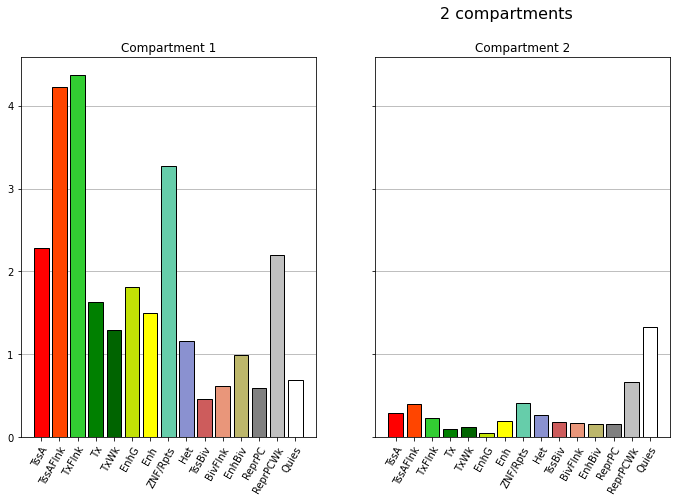

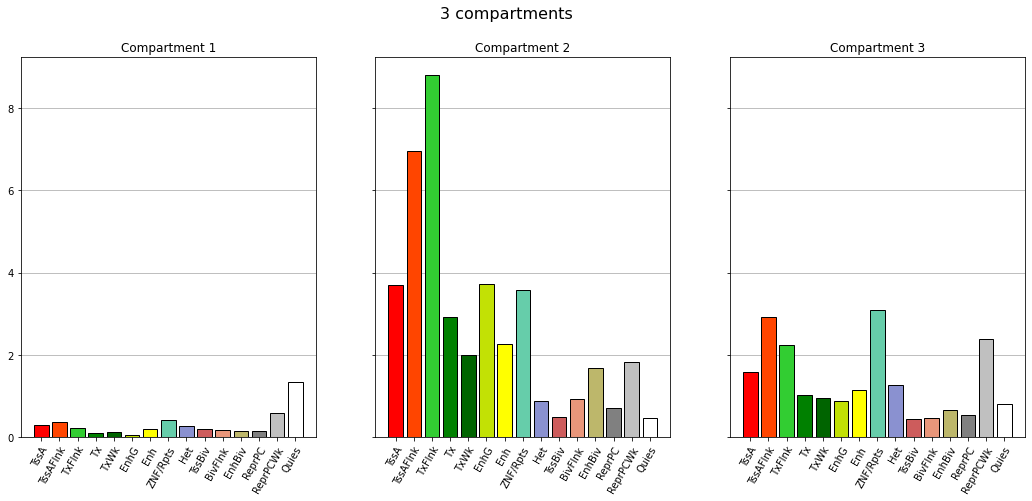

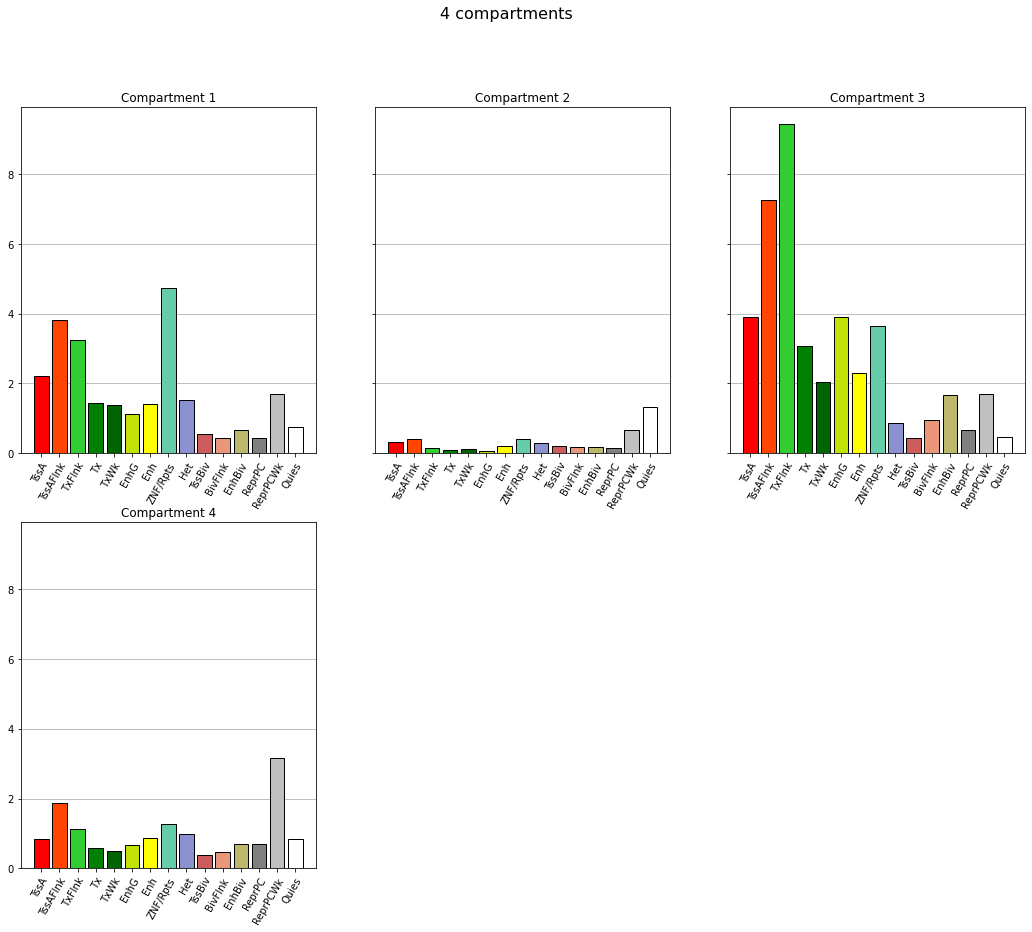

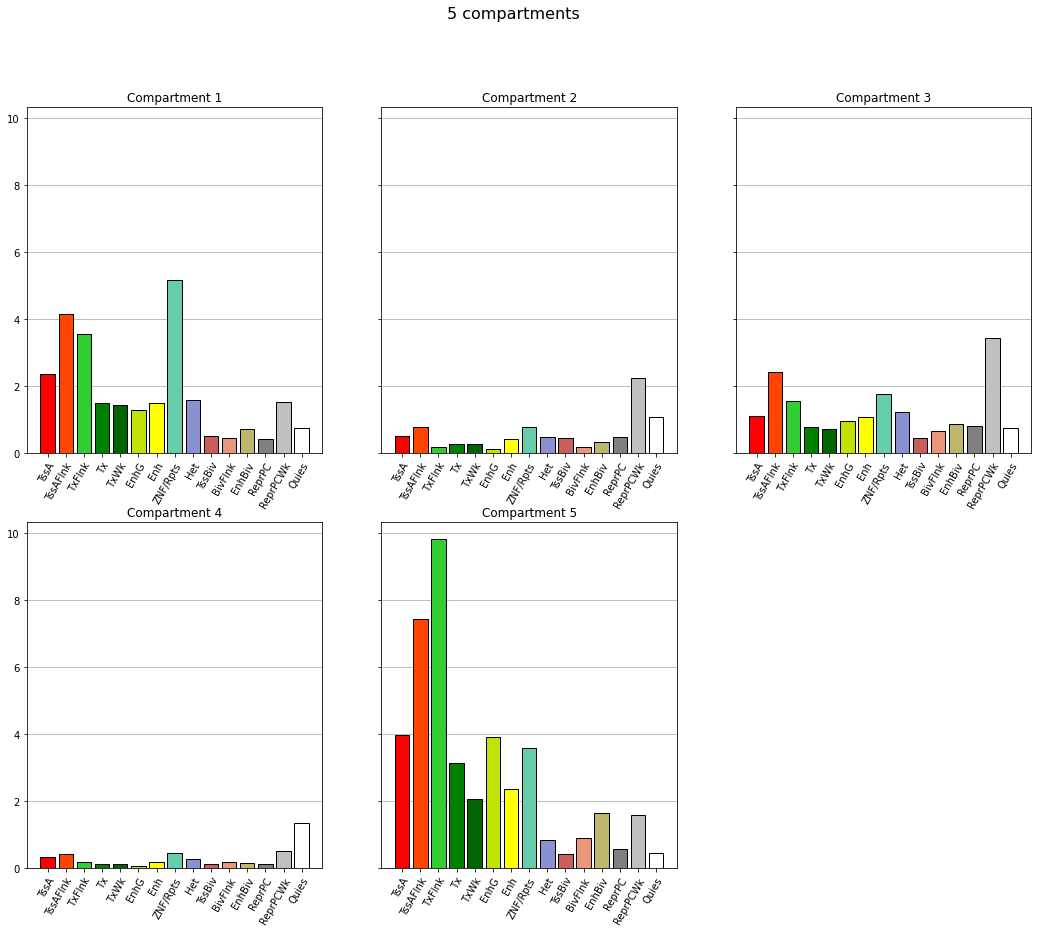

In [16]:
plot_epi(res_trimmed)
